# Voting et Stacking

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style = "darkgrid", palette = "colorblind")

from sklearn import tree, ensemble, linear_model, svm, neighbors
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.neighbors import NearestNeighbors

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

from joblib import dump, load # pour enregistrer et charger les modèles.

from IPython.display import display_html # pour pouvoir afficher deux df côte à côte.

n_coeurs = 4 # spécifie le nombre de coeurs utilisés sur le processeur par les fonctions qui le permettent (logreg, rdf, knn ici)

## 1.Préparation des données et chargement des modèles

In [4]:
# Instanciation df 
df = pd.read_csv('../../data/processed/model_weatherAUS.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

###### Proportions initiales target:
#RainTomorrow
#0    0.778382
#1    0.221618

# Séparation data / target:
X = df.drop(columns = ['RainTomorrow', 'Date']).copy()
y = df['RainTomorrow'].copy()

# Séparation du jeu d'entrainement et du jeu de test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y) 
# stratify = y assure que la proportion initiale de y se retrouve à l'identique dans les deux échantillons de train et test,
# mais ne permet pas de ré-équilibrer les classes!

# Scale de X_train, X_test:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Oversample avec SMOTE: pour pouvoir spécifier n_jobs, il faut désormais le faire en instanciant en amont un nearest neighbors compatible, ici NearestNeighbors
nn_smote = NearestNeighbors(n_neighbors = 5, n_jobs = n_coeurs)
smote = SMOTE(random_state = 12, k_neighbors = nn_smote)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

print('Classes échantillon SMOTE :', dict(pd.Series(y_sm).value_counts()))

C:\Users\AlexW\anaconda3\envs\projet_meteo\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Classes échantillon SMOTE : {0: 82189, 1: 82189}


In [5]:
# Chargement des grid: ADRESSE A MODIFIER EN FONCTION DU DF
grid_logreg = load('saves/grid_saves/grid_logreg.joblib')
grid_dt = load('saves/grid_saves/grid_dt.joblib')
grid_rdf = load('saves/grid_saves/grid_rdf.joblib')
grid_knn = load('saves/grid_saves/grid_knn.joblib')

# Chargement des modèles: ADRESSE A MODIFIER EN FONCTION DU DF
logreg = load('saves/model_saves/save_logreg.joblib')
dt = load('saves/model_saves/save_dt.joblib')
rdf = load('saves/model_saves/save_rdf.joblib')
knn = load('saves/model_saves/save_knn.joblib')

## 2. Voting

J'ai fait par ailleurs un essai avec un voting direct et les versions par défaut des classifieurs, on retrouve le même résultat quasiment.
Idem en ajoutant svm.
Ici on travaille avec les meilleurs estimateurs trouvés précédemment.

In [31]:
vclf_hard = VotingClassifier(estimators = [('logreg', logreg), ('dt', dt), ('rdf', rdf), ('knn', knn)], voting = 'hard')
vclf_hard.fit(X_train, y_train)
dump(vclf_hard, 'saves/model_saves/save_vclf_hard.joblib')

['saves/model_saves/save_vclf_hard.joblib']

### 2.1 Evaluation sur test

In [32]:
vclf_hard = load('saves/model_saves/save_vclf_hard.joblib')

In [34]:
y_test_pred = vclf_hard.predict(X_test)
cm = pd.crosstab(y_test,y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])
cm

Classes prédites,0,1
Classes réelles,,
0,26590,807
1,4261,3539


In [35]:
print(classification_report(y_test, y_test_pred,  digits = 2))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     27397
           1       0.81      0.45      0.58      7800

    accuracy                           0.86     35197
   macro avg       0.84      0.71      0.75     35197
weighted avg       0.85      0.86      0.84     35197



C'est le meilleur résultat obtenu jusqu'à présent.  
On ne peut pas chercher de meilleur seuil quand on utilise le voting 'hard'.

### 2.2 Evaluation sur train

In [21]:
y_train_pred = vclf.predict(X_train)
cm = pd.crosstab(y_train,y_train_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])
cm

Classes prédites,0,1
Classes réelles,,
0,82189,0
1,9380,14021


In [22]:
print(classification_report(y_train, y_train_pred,  digits = 2))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     82189
           1       1.00      0.60      0.75     23401

    accuracy                           0.91    105590
   macro avg       0.95      0.80      0.85    105590
weighted avg       0.92      0.91      0.90    105590



Il y a clairement overfitting.

### 2.3 Voting Soft

In [42]:
vclf_soft = VotingClassifier(estimators = [('logreg', logreg), ('dt', dt), ('rdf', rdf), ('knn', knn)], voting = 'soft')

vclf_soft.fit(X_train, y_train)

y_test_pred = vclf_soft.predict(X_test)
cm = pd.crosstab(y_test,y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])
cm


Classes prédites,0,1
Classes réelles,,
0,25932,1465
1,3613,4187


In [43]:
dump(vclf_soft, 'saves/model_saves/save_vclf_soft.joblib')

['saves/model_saves/save_vclf_soft.joblib']

In [44]:
vclf_soft = load('saves/model_saves/save_vclf_soft.joblib')

In [45]:
print(classification_report(y_test, y_test_pred,  digits = 2))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     27397
           1       0.74      0.54      0.62      7800

    accuracy                           0.86     35197
   macro avg       0.81      0.74      0.77     35197
weighted avg       0.85      0.86      0.85     35197



Je préfère la version 'hard', qui donne une meilleure précision sur la classe positive (82% contre 74% ici)

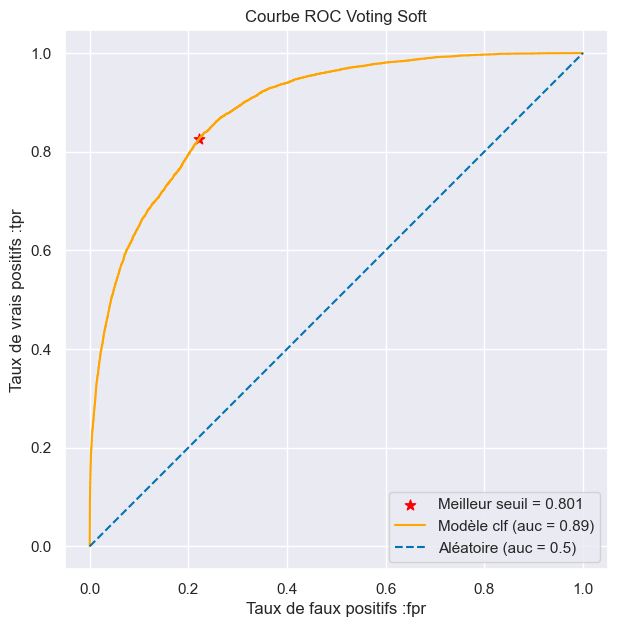

Report Voting Soft 
               precision    recall  f1-score   support

           0       0.82      1.00      0.90     27397
           1       0.94      0.22      0.36      7800

    accuracy                           0.82     35197
   macro avg       0.88      0.61      0.63     35197
weighted avg       0.84      0.82      0.78     35197

[[27281   116]
 [ 6089  1711]]


In [46]:
vclf_soft = load('saves/model_saves/save_vclf_soft.joblib')
# On fait la prediction sur test:
preds = vclf_soft.predict_proba(X_test)

################################ On cherche le meilleur seuil:
# Création des arrays fpr, tpr et seuils:
fpr, tpr, seuils = roc_curve(y_test, preds[:, 1], pos_label = 1) # on choisit pred[:, 1] pour prendre parmi les deux probas celle qui correspond à la classe positive.

# Pour calculer l'aire sous la courbe ROC:
roc_auc = auc(x = fpr, y = tpr)

# Comment trouver le meilleur seuil?
dist = 1
for (x, y, s) in zip(fpr, tpr, seuils):
    dist1 = np.square(x**2 + (y-1)**2) 
    if dist1 < dist:
        dist = dist1
        seuil_best = 1 - s # pourquoi dois-je faire ça?
        fpr_best = x
        tpr_best = y
        
#print("Meilleur seuil:", seuil_best, "meilleur fpr:", fpr_best, "meilleur tpr:", tpr_best)

# Tracé de ROC:
plt.figure(figsize = (7, 7))
plt.axis('equal')

plt.scatter(fpr_best, tpr_best, s = 60, c = 'red', marker = '*', alpha = 1, label = "Meilleur seuil = %0.3f" % seuil_best)
plt.plot(fpr, tpr, c = 'orange', label = 'Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (auc = 0.5)')

plt.title('Courbe ROC Voting Soft')
plt.xlabel('Taux de faux positifs :fpr')
plt.ylabel('Taux de vrais positifs :tpr')
plt.legend()

plt.show()

################### On applique le meilleur seuil:
y_pred = pd.Series(np.where(preds[:, 1] > seuil_best, 1, 0))

print("Report Voting Soft", "\n", classification_report(y_test, y_pred,  digits = 2))
print(confusion_matrix(y_test, y_pred))

Bilan: on obtient une très bonne précision, sur les deux classes à la fois: les signaux sont très propres.  
Par contre, le recall sur la classe positive est très mauvais, comme attendu.

## 3. Stacking

In [6]:
sclf = StackingClassifier(estimators = [('logreg', logreg), ('dt', dt), ('rdf', rdf), ('knn', knn)], final_estimator = logreg, n_jobs = n_coeurs)

In [8]:
sclf.fit(X_train, y_train)

StackingClassifier(estimators=[('logreg', LogisticRegression(C=0.01, n_jobs=4)),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=100)),
                               ('rdf',
                                RandomForestClassifier(criterion='entropy',
                                                       n_estimators=300,
                                                       n_jobs=4)),
                               ('knn',
                                KNeighborsClassifier(metric='manhattan',
                                                     n_jobs=4,
                                                     n_neighbors=10))],
                   final_estimator=LogisticRegression(C=0.01, n_jobs=4),
                   n_jobs=4)

In [13]:
dump(sclf, 'saves/model_saves/save_sclf.joblib')

['saves/model_saves/save_sclf.joblib']

In [9]:
y_test_pred = sclf.predict(X_test)
cm = pd.crosstab(y_test,y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])
cm

Classes prédites,0,1
Classes réelles,,
0,26074,1323
1,3445,4355


In [11]:
print("Report Stacking:","\n",  classification_report(y_test, y_test_pred,  digits = 2))

Report Stacking: 
               precision    recall  f1-score   support

           0       0.88      0.95      0.92     27397
           1       0.77      0.56      0.65      7800

    accuracy                           0.86     35197
   macro avg       0.83      0.76      0.78     35197
weighted avg       0.86      0.86      0.86     35197



bilan: C'est un peu moins précis que Voting Best, qui garde ma préférence.

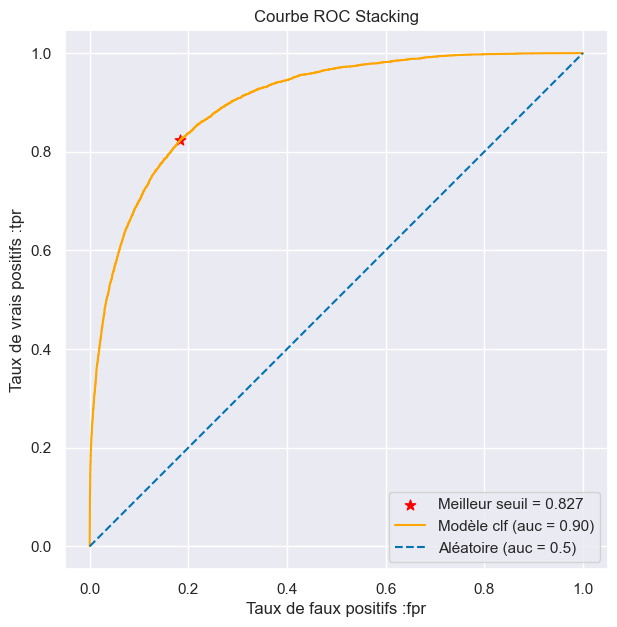

Report Stacking 
               precision    recall  f1-score   support

           0       0.83      0.99      0.90     27397
           1       0.91      0.29      0.44      7800

    accuracy                           0.84     35197
   macro avg       0.87      0.64      0.67     35197
weighted avg       0.85      0.84      0.80     35197

[[27168   229]
 [ 5513  2287]]


In [37]:
sclf = load('saves/model_saves/save_sclf.joblib')
# On fait la prediction sur test:
preds = sclf.predict_proba(X_test)

################################ On cherche le meilleur seuil:
# Création des arrays fpr, tpr et seuils:
fpr, tpr, seuils = roc_curve(y_test, preds[:, 1], pos_label = 1) # on choisit pred[:, 1] pour prendre parmi les deux probas celle qui correspond à la classe positive.

# Pour calculer l'aire sous la courbe ROC:
roc_auc = auc(x = fpr, y = tpr)

# Comment trouver le meilleur seuil?
dist = 1
for (x, y, s) in zip(fpr, tpr, seuils):
    dist1 = np.square(x**2 + (y-1)**2) 
    if dist1 < dist:
        dist = dist1
        seuil_best = 1 - s # pourquoi dois-je faire ça?
        fpr_best = x
        tpr_best = y
        
#print("Meilleur seuil:", seuil_best, "meilleur fpr:", fpr_best, "meilleur tpr:", tpr_best)

# Tracé de ROC:
plt.figure(figsize = (7, 7))
plt.axis('equal')

plt.scatter(fpr_best, tpr_best, s = 60, c = 'red', marker = '*', alpha = 1, label = "Meilleur seuil = %0.3f" % seuil_best)
plt.plot(fpr, tpr, c = 'orange', label = 'Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (auc = 0.5)')

plt.title('Courbe ROC Stacking')
plt.xlabel('Taux de faux positifs :fpr')
plt.ylabel('Taux de vrais positifs :tpr')
plt.legend()

plt.show()

################### On applique le meilleur seuil:
y_pred = pd.Series(np.where(preds[:, 1] > seuil_best, 1, 0))

print("Report Stacking", "\n", classification_report(y_test, y_pred,  digits = 2))
print(confusion_matrix(y_test, y_pred))

Bilan: c'est un peu meilleur sur le recall de la classe positive, c'est mon meilleur modèle precision-wise jusqu'à présent (14 nov 23, 11h50), à presque égalité avec XGBoost seuillé.